# **Práctica 2, FSI**
##### *Autoría de Juan Carlos Domínguez Dopazo, Asmae Ez Zaim Driouch*
##### *Grupo de prácticas 43*

---

####  *1. Introducción*


---


El objetivo principal de esta práctica es desarrollar una red neuronal con la capacidad de identificar diferentes tipos de vegetales. Para llevar a cabo este proceso, utilizamos el conjunto de datos "Vegetable Image Dataset", el cual está disponible de manera gratuita en este [enlace](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset).

Para esta práctica, en total tenemos 15 categorías en el dataset:

- Brócoli
- Zanahoria
- Pepino
- Patata
- Calabaza
- Tomate
- Judía
- Calabaza amarga
- Calabaza de botella
- Berenjena
- Repollo
- Pimiento rojo
- Coliflor
- Papaya
- Rábano

El objetivo final es lograr que nuestra red neuronal pueda diferenciar entre vegetales al analizar las imágenes proporcionadas. Este proceso implica entrenar la red para que pueda aprender y reconocer patrones específicos asociados con dichas verduras, permitiendo así su clasificación precisa en función de las características presentes en las imágenes.

En primer lugar, se comprueba que se esté utilizando una GPU, tras haber instalado correctamente las librerías de CUDA, Tensorflow y paquetes necesarios:

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'


####  *2. Data augmentation*


---



El aumento de datos, o data augmentation, es una técnica utilizada  para aumentar la cantidad de datos de entrenamiento mediante la aplicación de transformaciones a las muestras de datos existentes. Estas transformaciones generan nuevas instancias de datos que son variaciones ligeras de las originales.

Esto permite:

- Aumentar la diversidad del conjunto de datos
- Mejorar la robustez del modelo
- Prevención del sobreajuste

En el ámbito del reconocimiento de vegetales, la aplicación de técnicas de aumento de datos resulta ventajosa por diversas razones. Primero, la variabilidad en la posición y orientación de las verduras en las imágenes se aborda mediante transformaciones como rotación y volteo, permitiendo al modelo aprender a reconocer características clave.

Esto facilita la generalización del modelo a nuevas instancias de imágenes de medusas que no formaban parte del conjunto de datos original, contribuyendo así a una mayor robustez y capacidad predictiva del modelo.

En este código, el aumento de datos se realiza mediante la clase ImageDataGenerator de TensorFlow/Keras. Las imágenes generadas se guardan en una carpeta dentro de cada tipo de especie para los directorios de entrenamiento. Hemos decidido realizar manualmente el proceso de aumento de datos con un script de Python, en vez de incluirlo en el entrenamiento para reducir la carga:


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os

datagen = ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    rotation_range=25,
    zoom_range=0.20,
    shear_range=0.20,
    fill_mode="nearest"
)

base_path = "train/"

for i in range(0, 15, 1):
    categories = ("Bean", "Bitter_Gourd", "Bottle_Gourd", "Brinjal", "Broccoli", "Cabbage",  "Capsicum", "Carrot",
                   "Cauliflower", "Cucumber", "Papaya", "Potato", "Pumpkin", "Radish", "Tomato")
    categories_path = os.path.join(base_path, categories[i])

    try:
        files = os.listdir(categories_path)
        if not files:
            continue
        else:
            for file in files:
                img_path = os.path.join(categories_path, file)
                img = load_img(img_path)
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)
                j = 0
                # Guardar en el directorio base de cada categoría
                for batch in datagen.flow(x, batch_size=1,
                                          save_to_dir=categories_path,
                                          save_prefix="image", save_format='jpg'):
                    j += 1
                    if j >= 2:
                        break

    except OSError as e:
        print(f"Error while listing files from this directory: {e}")

print("Data augmentation done")

Data augmentation done


Una vez realizado el aumento de datos, se configuran los parámetros de entrenamiento de la red neuronal.


####  *3. Red neuronal*


---

El modelo de datos sigue un flujo típico para el entrenamiento de modelos de clasificación de imágenes.

Primero, se utiliza image_dataset_from_directory para cargar el conjunto de datos desde un directorio, dividiéndolo en conjuntos de entrenamiento y validación, donde se establece el tamaño de imagen específico, se normaliza y se almacenan en train_ds y val_ds. También se realiza una separación por categorías.

Luego, se define un modelo de red neuronal. El modelo consiste en capas convolucionales, donde las capas  son "filtros" que encuentran patrones en las imágenes, las capas de reducción simplifican esas imágenes, y las capas de dropout evitan que el modelo se "sobreaprenda" a las imágenes de entrenamiento. Las capas densas y la capa de salida softmax ayudan al modelo a clasificar las imágenes en seis categorías.

Una vez realizado el entrenamiento de la red, el conjunto de validación ayuda a verificar el funcionamiento y precisión del mismo.

In [2]:
# ---- DATA SOURCE ----

import tensorflow as tf

image_size = (224, 224)
batch_size = 32

# Se cargan las imágenes de entrenamiento
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Se cargan las imágenes de validación
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 57619 files belonging to 15 classes.
Using 46096 files for training.
Found 57619 files belonging to 15 classes.
Using 11523 files for validation.


Para garantizar la integridad de los datos y comprobar que la información se ha cargado correctamente, procederemos a visualizar una imagen aleatoria del conjunto de datos. Esta acción nos permitirá asegurarnos de que las imágenes están correctamente etiquetadas:

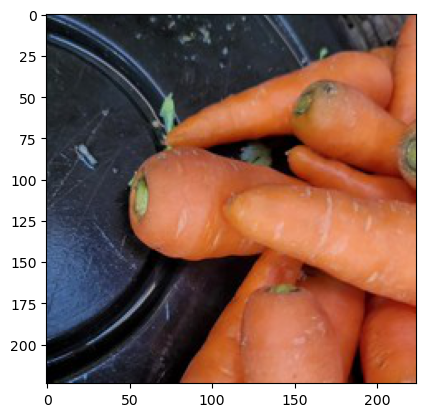

In [3]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline

# Se muestra una imagen cualquiera de ejemplo
pil_im = Image.open('train/Carrot/0001.jpg', 'r')
imshow(np.asarray(pil_im))

Posteriormente, se configuran los parámetros de la red:

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5),
                    offset=-1,
                    # Input image rescaling (224x224px)
                    input_shape=(224, 224, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Nueva capa Conv2D
model.add(Conv2D(128, (3, 3), activation='relu'))
# Nueva capa de MaxPooling2D
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

# Mostrar resumen del modelo con información sobre parámetros y capas
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 54, 54, 64)        0

Se configura el early stopping y comienza el entrenamiento:

In [5]:
# --- TRAINING ---
epochs = 25

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/25
1441/1441 [==============================] - 96s 64ms/step - loss: 0.9271 - accuracy: 0.6952 - val_loss: 0.2566 - val_accuracy: 0.9281
Epoch 2/25
1441/1441 [==============================] - 92s 64ms/step - loss: 0.3138 - accuracy: 0.9009 - val_loss: 0.1528 - val_accuracy: 0.9516
Epoch 3/25
1441/1441 [==============================] - 92s 64ms/step - loss: 0.1994 - accuracy: 0.9369 - val_loss: 0.1339 - val_accuracy: 0.9562
Epoch 4/25
1441/1441 [==============================] - 92s 64ms/step - loss: 0.1543 - accuracy: 0.9525 - val_loss: 0.0925 - val_accuracy: 0.9724
Epoch 5/25
1441/1441 [==============================] - 92s 64ms/step - loss: 0.1275 - accuracy: 0.9607 - val_loss: 0.0637 - val_accuracy: 0.9810
Epoch 6/25
1441/1441 [==============================] - 92s 64ms/step - loss: 0.1040 - accuracy: 0.9683 - val_loss: 0.0520 - val_accuracy: 0.9853
Epoch 7/25
1441/1441 [==============================] - 92s 64ms/step - loss: 0.0984 - accuracy: 0.9711 - val_loss: 0.0403 -

Se representan los resultados:

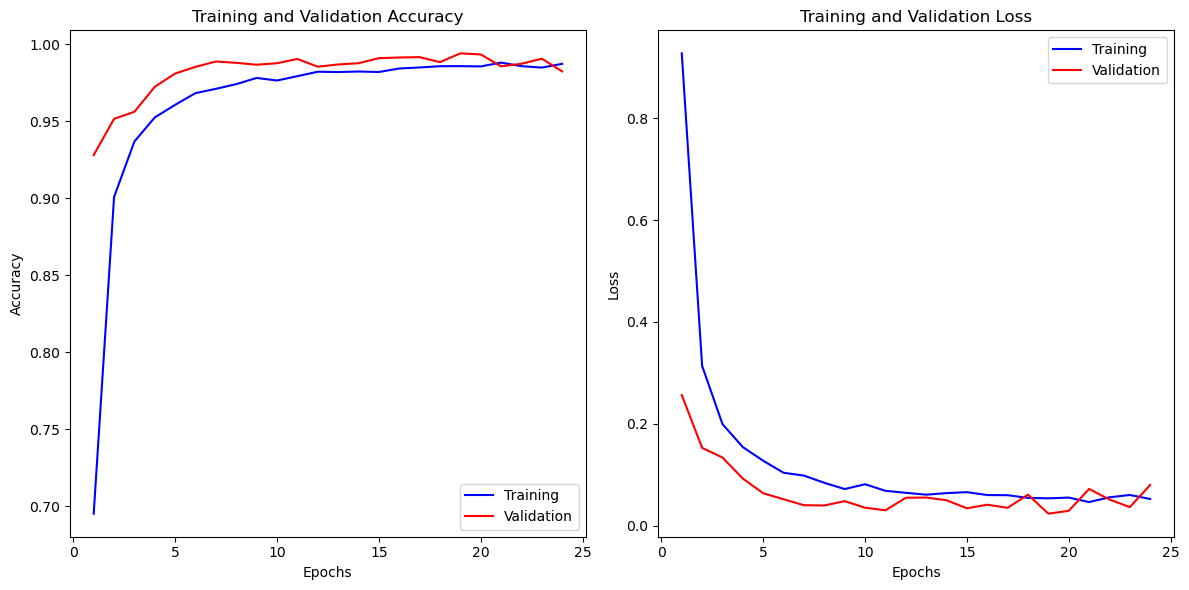

In [6]:
import matplotlib.pyplot as plt

def generatePlot(history):
    # Extracción de datos
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Creación del gráfico de accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Creación del gráfico de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

generatePlot(h)

1/1 [==============================] - 0s 47ms/step
              precision    recall  f1-score   support

           0     0.9987    0.9936    0.9961       776
           1     0.9919    1.0000    0.9960       739
           2     0.9963    0.9963    0.9963       802
           3     0.9897    0.9922    0.9910       774
           4     0.9913    0.9988    0.9950       801
           5     0.9909    0.9871    0.9890       775
           6     0.9909    0.9987    0.9948       764
           7     0.9962    1.0000    0.9981       783
           8     0.9960    0.9829    0.9894       759
           9     0.9918    0.9945    0.9931       727
          10     0.9932    0.9866    0.9899       745
          11     0.9987    0.9974    0.9980       765
          12     0.9938    0.9866    0.9902       819
          13     1.0000    0.9986    0.9993       734
          14     0.9922    0.9987    0.9954       760

    accuracy                         0.9941     11523
   macro avg     0.9941    0

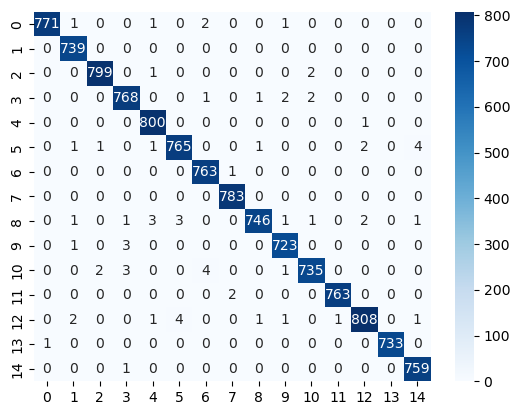

In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

Finalmente, la red demuestra que para tareas de reconocimiento de patrones y clasificación la red se dota de un buen rendimiento y tasa de eficiencia para el modelo de datos.